<a href="https://colab.research.google.com/github/Abibsb/DSIII_NLP/blob/main/DSIII_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajo Final Data Science III - NLP & Deep Learning

#**Generador de letras de canciones a través de un modelo de  neuronal recurrente**


##Introducción


El procesamiento de lenguaje natural (NLP por sus siglas en inglés) se enfoca n la interacción entre el las computadoras y el lenguaje humano. Principalmente se basa en el aprendizaje automático para procesar e interpretar textos para llegar a funcionalidades más complejas como la traducción de textos, análisis de sentimientos y generación de textos.

Sus aplicaciones pueden encontrarse en todos los sectores, desde análisis de comportamiento en redes sociales para estrategias de marketing, procesamiento de registros médicos para optimizar toma de desiciones y llamadas telefónicas digitales, entre otros.

En este trabajo se utilizaron modelos de redes neuronales para sintetizar un generador de canciones de una artista en particular a partir de las letras de su discografía.

---
### Metodología
Las letras de todas sus canciones se recuperaron de [genius.com](https://genius.com/),  uno de los repositorios más completos disponibles. Para generar los datasets para el análisis, modelado y generación se usó la API diseñada para esta web, junto con una serie de scripts para agrupar y limpiar las letras (los detalles y correspondientes scripts se encuentran en el [Readme del repositorio del proyecto](https://github.com/Abibsb/DSIII_NLP?tab=readme-ov-file#trabajo-final--generador-de-letras-de-canciones-a-trav%C3%A9s-de-un-modelo-de-neuronal-recurrente).

Se presentaron dos datasets: uno con las letras sólo de discos de estudio y otro con letras al que se añadió las letras de singles, bandas sonoras y  discos en colaboración con otros artistas.



In [27]:
#Librerias requeridas
!pip install tensorflow wordcloud scikit-learn matplotlib nltk


In [28]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Análisis exploratorio

**Dataset sólo de discos de estudio**

In [29]:
df_csv = pd.read_csv('/content/all_st_vincent_lyrics_cleaned_sololps.csv')

def filter_stopwords(df, column='Lyrics'):
    """Remove stopwords and small/unwanted words from the lyrics column and convert to lowercase."""
    stopwords_list = stopwords.words('english')
    filtered_lyrics = df[column].dropna().apply(
        lambda x: ' '.join(
            [word.lower() for word in x.split() if word.lower() not in stopwords_list and len(word) > 1 and word.lower() not in ['na', 'la']]
        )
    )
    return pd.DataFrame({column: filtered_lyrics, 'Title': df['Title']})

# Apply the filtering function
filtered_df = filter_stopwords(df_csv, column='Lyrics')

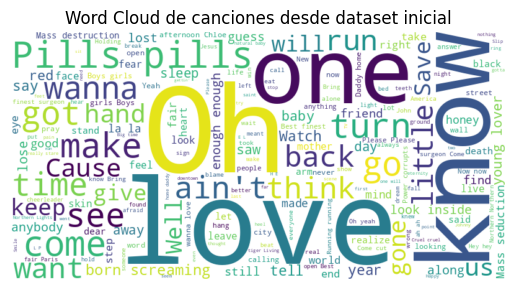

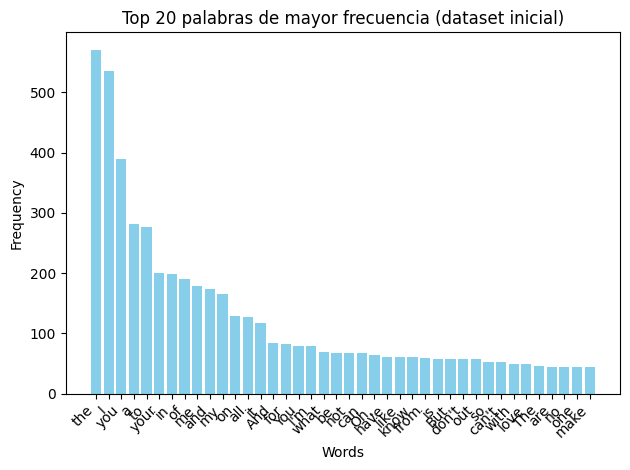

In [30]:
# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_csv['Lyrics'].dropna()))
#plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud de canciones desde dataset inicial')
plt.axis('off')
plt.show()
# Top Word Frequency Analysis
all_lyrics = ' '.join(df_csv['Lyrics'])
words = all_lyrics.split()
word_counts = Counter(words)
top_20_words = word_counts.most_common(40)
# Bar Plot for Top Words
words, counts = zip(*top_20_words)
#plt.figure(figsize=(16, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 palabras de mayor frecuencia (dataset inicial)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

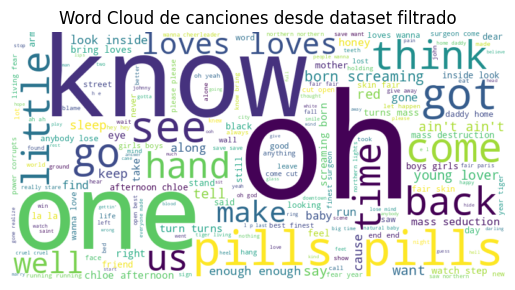

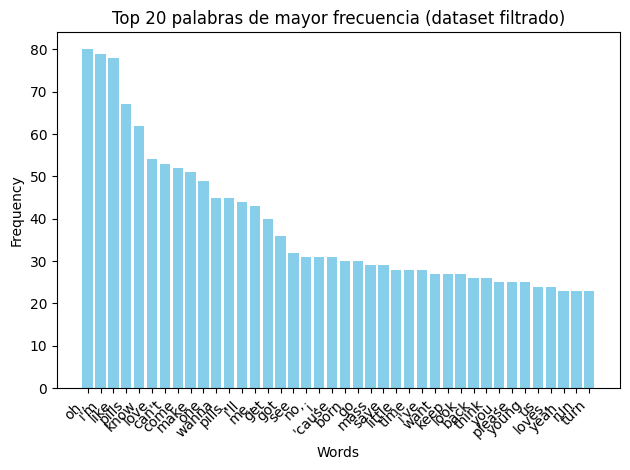

In [31]:
# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_df['Lyrics']))
#plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud de canciones desde dataset filtrado')
plt.axis('off')
plt.show()
# Top Word Frequency Analysis
all_lyrics = ' '.join(filtered_df['Lyrics'])
words = all_lyrics.split()
word_counts = Counter(words)
top_20_words = word_counts.most_common(40)
# Bar Plot for Top Words
words, counts = zip(*top_20_words)
#plt.figure(figsize=(16, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 palabras de mayor frecuencia (dataset filtrado)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En este análisis inicial se observó el dataset inicial y el dataset filtrado con la función stopwords de nltk, la cual elimina palabras comunes (conectores, adverbios, etc) que podrían considerarse background noise.

Al comparar ambos datasets puede verse rápidamente la alta frecuencia de estas palabras de bajo significado. Mientras que las palabras de mayor frecuencia en el dataset inicial llegan a valores cercanos a 500 repeticiones, as palabras con mayor presencia en el dataset limpio se acercan a 80 repeticiones (like, pills, know y love).

In [32]:
# Check the structure of the filtered DataFrame
filtered_df.head(), filtered_df.columns
# Initialize DataFrames for word counts and lexical richness
df1 = pd.DataFrame(columns=('Title', 'Words'))
df2 = pd.DataFrame(columns=('Title', 'Lexical Richness'))
# Iterate through each filtered lyric
for i, (title, lyrics) in filtered_df[['Title', 'Lyrics']].iterrows():
    words = lyrics.split()
    num_words = len(words)
    unique_words = len(set(words))
    lexical_richness = (unique_words / float(num_words)) * 100

    df1.loc[i] = (title, num_words)
    df2.loc[i] = (title, lexical_richness)

<Figure size 1600x800 with 0 Axes>

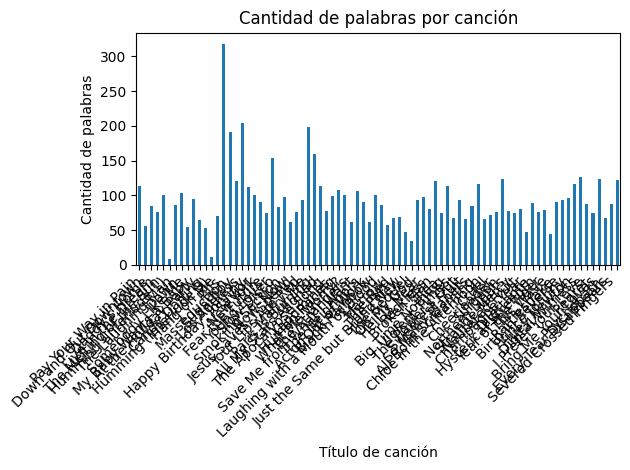

<Figure size 1600x800 with 0 Axes>

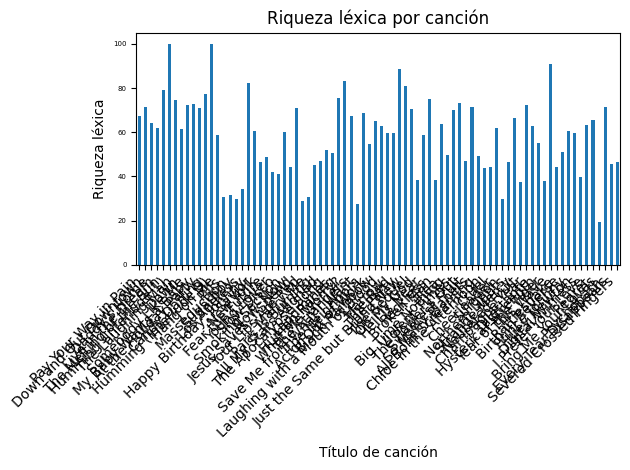

In [33]:
plt.figure(figsize=(16, 8))
df1.plot.bar(x='Title', y='Words', title='Cantidad de palabras por canción', legend=False)
plt.xlabel('Título de canción')
plt.ylabel('Cantidad de palabras')
plt.xticks(rotation=45, ha='right')  # Rotating the x-axis labels for
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
df2.plot.bar(x='Title', y='Lexical Richness', title='Riqueza léxica por canción', legend=False)
plt.xlabel('Título de canción')
plt.ylabel('Riqueza léxica')
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=5)
plt.tight_layout()
plt.show()

Si definimos riqueza léxica como la diversidad de palabras, no se observa una relación proporcional entre ésta y cantidad de palabras. Sin embargo, la discografía mantiene una riqueza léxica relativamente alta.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Análisis de sentimiento de todas las canciones:
Positivo: 55.00%
Neutral: 13.75%
Negativo: 31.25%


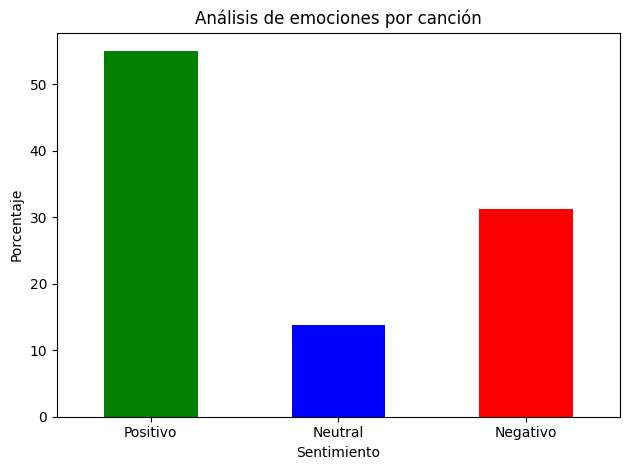

In [34]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()
# Perform Sentiment Analysis
sentiments = {'Positivo': 0, 'Neutral': 0, 'Negativo': 0}
for lyric in filtered_df['Lyrics'].dropna():
    comp = sid.polarity_scores(lyric)['compound']
    if comp >= 0.5:
        sentiments['Positivo'] += 1
    elif comp > -0.5:
        sentiments['Neutral'] += 1
    else:
        sentiments['Negativo'] += 1
# Calculate Percentages
total = sum(sentiments.values())
percentages = {key: (value / total) * 100 for key, value in sentiments.items()}
# Print Results
print("Análisis de sentimiento de todas las canciones:")
for sentiment, percentage in percentages.items():
    print(f"{sentiment}: {percentage:.2f}%")
# Create a DataFrame for the percentages
df_percentages = pd.DataFrame({
    'Sentiment': ['Positivo', 'Neutral', 'Negativo'],
    'Percentage': [percentages['Positivo'], percentages['Neutral'], percentages['Negativo']]
})
# Plot the results with distinct colors
ax = df_percentages.plot.bar(
    x='Sentiment',
    y='Percentage',
    color=['green', 'blue', 'red'],  # Assign specific colors to each sentiment
    legend=False
)
# Add labels and title
plt.title("Análisis de emociones por canción")
plt.xlabel("Sentimiento")
plt.ylabel("Porcentaje")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Utilizando VADER para la asignación de valores de sentimientos, puede decirse que la discografía de estudio presenta emociones positivas en la mitad de su trabajo. También se observa una presencia importante de emociones negativas.

**Dataset completo**

In [35]:
df_csv2 = pd.read_csv('/content/all_st_vincent_lyrics_clean.csv')

def filter_stopwords(df, column='Lyrics'):
    """Remove stopwords and small/unwanted words from the lyrics column and convert to lowercase."""
    stopwords_list = stopwords.words('english')
    filtered_lyrics = df[column].dropna().apply(
        lambda x: ' '.join(
            [word.lower() for word in x.split() if word.lower() not in stopwords_list and len(word) > 1 and word.lower() not in ['na', 'la']]
        )
    )
    return pd.DataFrame({column: filtered_lyrics, 'Title': df['Title']})

# Apply the filtering function
filtered_df2 = filter_stopwords(df_csv2, column='Lyrics')

(-0.5, 799.5, 399.5, -0.5)

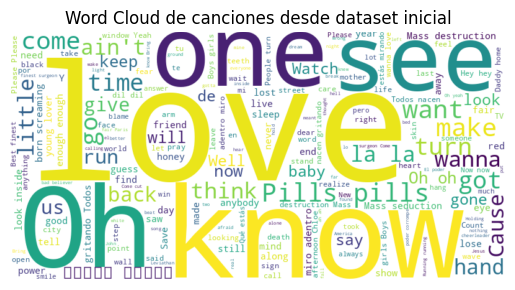

In [36]:
# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_csv2['Lyrics'].dropna()))
#plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud de canciones desde dataset inicial')
plt.axis('off')

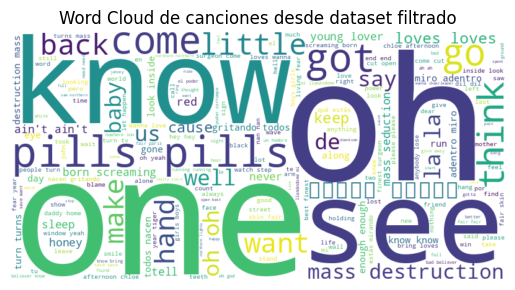

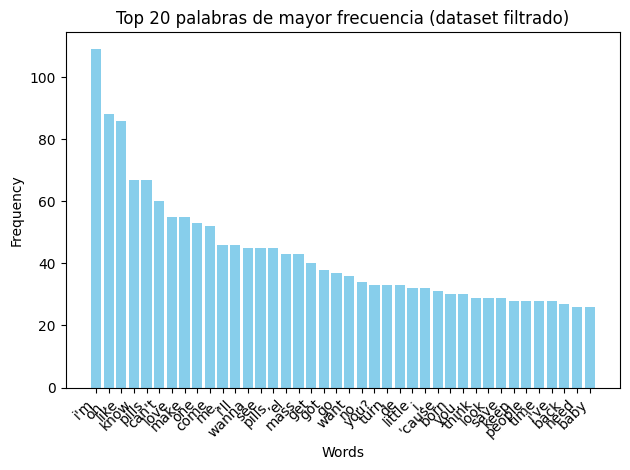

In [37]:
filtered_df2['Lyrics'] = filtered_df2['Lyrics'].astype(str)

# Eliminar valores NaN si es necesario
filtered_df2 = filtered_df2.dropna(subset=['Lyrics'])
# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_df2['Lyrics']))
#plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud de canciones desde dataset filtrado')
plt.axis('off')
plt.show()
# Top Word Frequency Analysis
all_lyrics = ' '.join(filtered_df2['Lyrics'])
words = all_lyrics.split()
word_counts = Counter(words)
top_20_words = word_counts.most_common(40)
# Bar Plot for Top Words
words, counts = zip(*top_20_words)
#plt.figure(figsize=(16, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 palabras de mayor frecuencia (dataset filtrado)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Puede observarse que se mantienen las mismas palabras de mayor frecuencia que en la discografía de estudio.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Análisis de sentimiento de todas las canciones:
Positivo: 43.90%
Neutral: 31.71%
Negativo: 24.39%


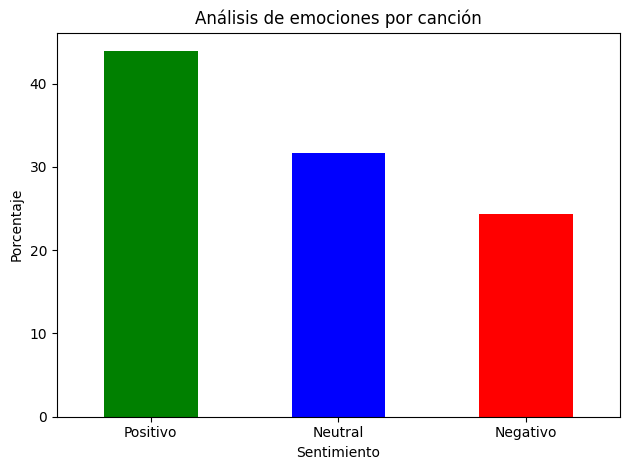

In [38]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()
# Perform Sentiment Analysis
sentiments = {'Positivo': 0, 'Neutral': 0, 'Negativo': 0}
for lyric in filtered_df2['Lyrics'].dropna():
    comp = sid.polarity_scores(lyric)['compound']
    if comp >= 0.5:
        sentiments['Positivo'] += 1
    elif comp > -0.5:
        sentiments['Neutral'] += 1
    else:
        sentiments['Negativo'] += 1
# Calculate Percentages
total = sum(sentiments.values())
percentages = {key: (value / total) * 100 for key, value in sentiments.items()}
# Print Results
print("Análisis de sentimiento de todas las canciones:")
for sentiment, percentage in percentages.items():
    print(f"{sentiment}: {percentage:.2f}%")
# Create a DataFrame for the percentages
df_percentages = pd.DataFrame({
    'Sentiment': ['Positivo', 'Neutral', 'Negativo'],
    'Percentage': [percentages['Positivo'], percentages['Neutral'], percentages['Negativo']]
})
# Plot the results with distinct colors
ax = df_percentages.plot.bar(
    x='Sentiment',
    y='Percentage',
    color=['green', 'blue', 'red'],  # Assign specific colors to each sentiment
    legend=False
)
# Add labels and title
plt.title("Análisis de emociones por canción")
plt.xlabel("Sentimiento")
plt.ylabel("Porcentaje")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Con el dataset completo, aumenta el porcentaje de emociones neutrales, disminuyen las emociones positivas y las negativas.

###Comparativa entre idiomas

Lista de canciones de ambos albumes

El último disco de St. Vincent fue publicado en inglés y en español, traducido por ella junto con un amigo que habla español con fluidez:


> "Los orígenes de ‘Todos Nacen Gritando’ se remontan a algunos de los espectáculos más memorables que he presentado en México, Sudamérica y recientemente en Primavera Barcelona de 2023. [...] Al final me pregunté: si ellos pueden cantar en un segundo o tercer idioma, ¿por qué no puedo llegar a un punto medio? Así que recluté a mi mejor amigo y colaborador ocasional, Alan Del Rio Ortiz, para que trabajara en la traducción de estas letras, modificando aquí y allá por razones melódicas, haciendo todo lo posible por permanecer fiel a la canción en cuestión sin sacrificar la precisión."

*Tracklist comparado de ambos discos*

| All Born Screaming | Todos Nacen Gritando |
|:----------:|:----------:|
| Hell is Near | El Infierno Está Cerca |
| Reckless | Salvaje |
| Broken Man | Hombre Roto |
| Flea | Pulga |
| Big Time Nothing | El Mero Cero |
| Violent Times | Tiempos Violentos |
| The Power's Out | Se Fue La Luz |
| Sweetest Fruit | La Fruta Más Dulces |
| So Many Planets | Tantos Planetas |
| All Born Screaming | Todos Nacen Gritando |

####Inglés

In [39]:
df_csv_1 = pd.read_csv('all_born_screaming_lyrics_clean.csv')

def filter_stopwords(df, column='Lyrics'):
    """Remove stopwords and small/unwanted words from the lyrics column and convert to lowercase."""
    stopwords_list = stopwords.words('english')
    filtered_lyrics = df[column].dropna().apply(
        lambda x: ' '.join(
            [word.lower() for word in x.split() if word.lower() not in stopwords_list and len(word) > 1 and word.lower() not in ['na', 'la']]
        )
    )
    return pd.DataFrame({column: filtered_lyrics, 'Title': df['Title']})

# Apply the filtering function
filtered_df_1 = filter_stopwords(df_csv_1, column='Lyrics')

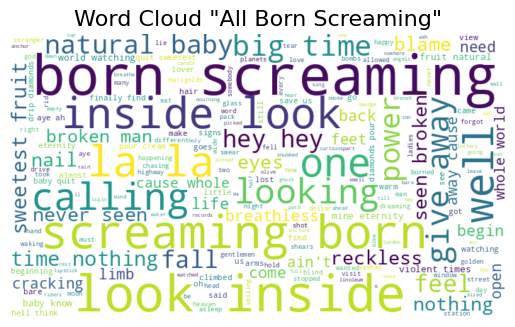

In [40]:
wordcloud = WordCloud(width=700, height=400, background_color='white').generate(' '.join(filtered_df_1['Lyrics']))
#plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud "All Born Screaming"', fontsize =16)
plt.axis('off')
plt.show()

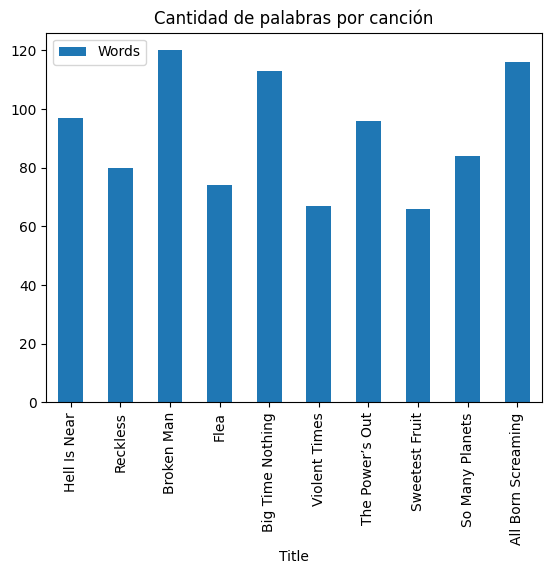

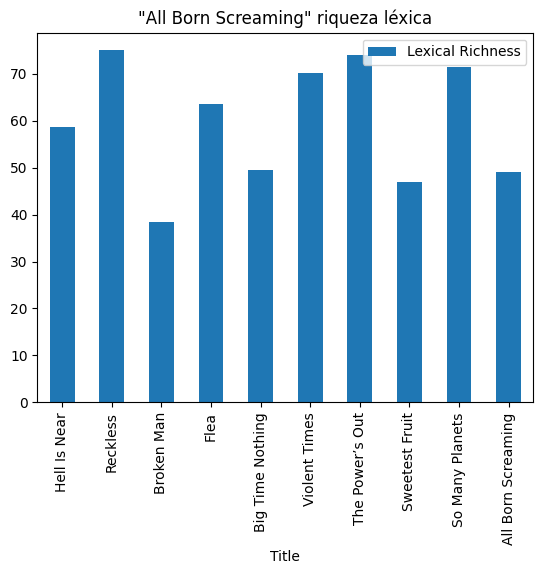

In [41]:
filtered_df_1.head(), filtered_df_1.columns
# Initialize DataFrames for word counts and lexical richness
df1 = pd.DataFrame(columns=('Title', 'Words'))
df2 = pd.DataFrame(columns=('Title', 'Lexical Richness'))
# Iterate through each filtered lyric
for i, (title, lyrics) in filtered_df_1[['Title', 'Lyrics']].iterrows():
    words = lyrics.split()
    num_words = len(words)
    unique_words = len(set(words))
    lexical_richness = (unique_words / float(num_words)) * 100

    df1.loc[i] = (title, num_words)
    df2.loc[i] = (title, lexical_richness)
# Plot word count and lexical richness
df1.plot.bar(x='Title', y='Words', title='Cantidad de palabras por canción')
plt.show()
df2.plot.bar(x='Title', y='Lexical Richness', title='"All Born Screaming" riqueza léxica')
plt.show()

Porcentaje de emociones:
Positivo: 50.00%
Neutral: 10.00%
Negativo: 40.00%


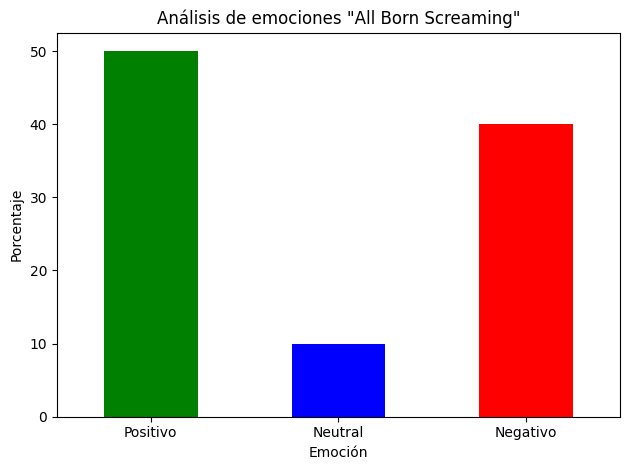

In [42]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()
# Perform Sentiment Analysis
sentiments = {'Positivo': 0, 'Neutral': 0, 'Negativo': 0}
for lyric in filtered_df_1['Lyrics'].dropna():
    comp = sid.polarity_scores(lyric)['compound']
    if comp >= 0.5:
        sentiments['Positivo'] += 1
    elif comp > -0.5:
        sentiments['Neutral'] += 1
    else:
        sentiments['Negativo'] += 1
# Calculate Percentages
total = sum(sentiments.values())
percentages = {key: (value / total) * 100 for key, value in sentiments.items()}
# Print Results
print("Porcentaje de emociones:")
for sentiment, percentage in percentages.items():
    print(f"{sentiment}: {percentage:.2f}%")
# Create a DataFrame for the percentages
df_percentages = pd.DataFrame({
    'Emoción': ['Positivo', 'Neutral', 'Negativo'],
    'Porcentaje': [percentages['Positivo'], percentages['Neutral'], percentages['Negativo']]
})
# Plot the results with distinct colors
ax = df_percentages.plot.bar(
    x='Emoción',
    y='Porcentaje',
    color=['green', 'blue', 'red'],  # Assign specific colors to each sentiment
    legend=False
)
plt.title('Análisis de emociones "All Born Screaming"')
plt.ylabel("Porcentaje")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

####Español

In [43]:
df_csv_2 = pd.read_csv('todos_nacen_gritando_lyrics_clean.csv')

def filter_stopwords(df, column='Lyrics'):
    """Remove stopwords and small/unwanted words from the lyrics column and convert to lowercase."""
    stopwords_list = stopwords.words('spanish')
    filtered_lyrics = df[column].dropna().apply(
        lambda x: ' '.join(
            [word.lower() for word in x.split() if word.lower() not in stopwords_list and len(word) > 1 and word.lower() not in ['na', 'la']]
        )
    )
    return pd.DataFrame({column: filtered_lyrics, 'Title': df['Title']})

# Apply the filtering function
filtered_df_2 = filter_stopwords(df_csv_2, column='Lyrics')

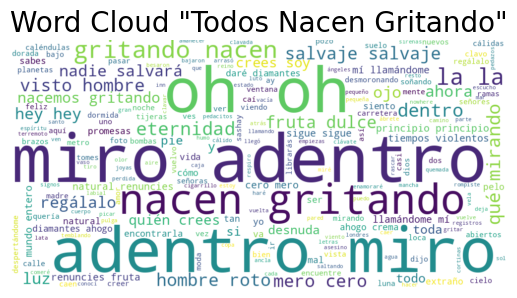

In [44]:
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(' '.join(filtered_df_2['Lyrics']))
#plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud "Todos Nacen Gritando"', fontsize =20)
plt.axis('off')
plt.show()

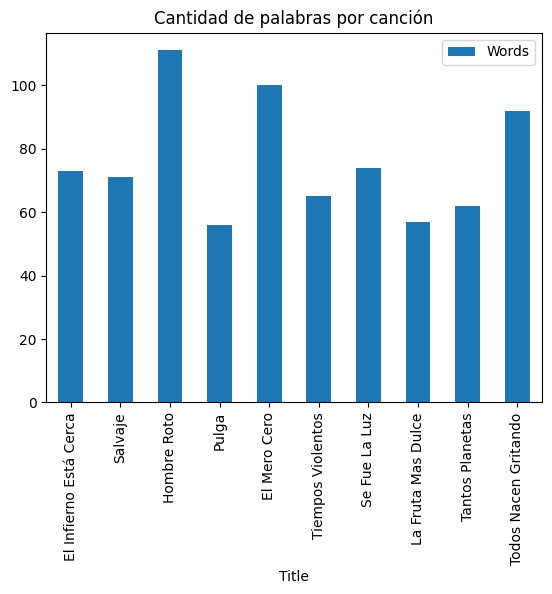

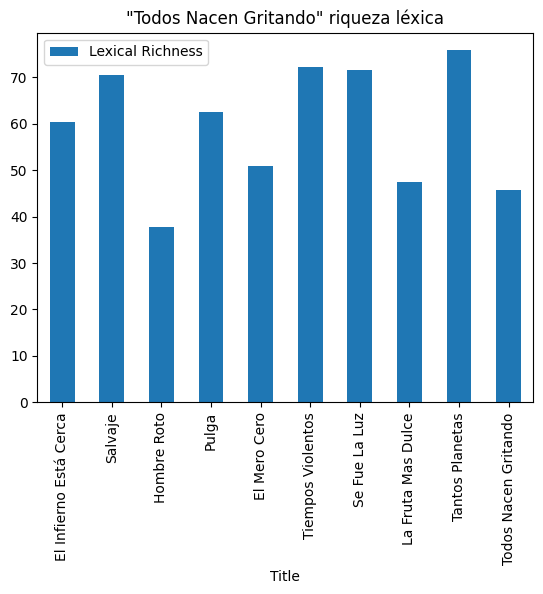

In [45]:
filtered_df_2.head(), filtered_df_2.columns
# Initialize DataFrames for word counts and lexical richness
df1 = pd.DataFrame(columns=('Title', 'Words'))
df2 = pd.DataFrame(columns=('Title', 'Lexical Richness'))
# Iterate through each filtered lyric
for i, (title, lyrics) in filtered_df_2[['Title', 'Lyrics']].iterrows():
    words = lyrics.split()
    num_words = len(words)
    unique_words = len(set(words))
    lexical_richness = (unique_words / float(num_words)) * 100

    df1.loc[i] = (title, num_words)
    df2.loc[i] = (title, lexical_richness)
# Plot word count and lexical richness
df1.plot.bar(x='Title', y='Words', title='Cantidad de palabras por canción')
plt.show()
df2.plot.bar(x='Title', y='Lexical Richness', title='"Todos Nacen Gritando" riqueza léxica')
plt.show()

Sentiment analysis for artist:
Positivo: 30.00%
Neutral: 50.00%
Negativo: 20.00%


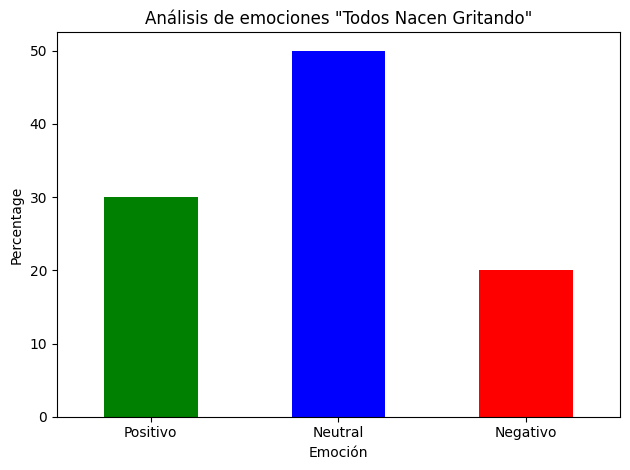

In [46]:
sid = SentimentIntensityAnalyzer()
# Perform Sentiment Analysis
sentiments = {'Positivo': 0, 'Neutral': 0, 'Negativo': 0}
for lyric in filtered_df_2['Lyrics'].dropna():
    comp = sid.polarity_scores(lyric)['compound']
    if comp >= 0.5:
        sentiments['Positivo'] += 1
    elif comp > -0.5:
        sentiments['Neutral'] += 1
    else:
        sentiments['Negativo'] += 1
# Calculate Percentages
total = sum(sentiments.values())
percentages = {key: (value / total) * 100 for key, value in sentiments.items()}
# Print Results
print("Sentiment analysis for artist:")
for sentiment, percentage in percentages.items():
    print(f"{sentiment}: {percentage:.2f}%")
# Create a DataFrame for the percentages
df_percentages = pd.DataFrame({
    'Emoción': ['Positivo', 'Neutral', 'Negativo'],
    'Porcentaje': [percentages['Positivo'], percentages['Neutral'], percentages['Negativo']]
})
# Plot the results with distinct colors
ax = df_percentages.plot.bar(
    x='Emoción',
    y='Porcentaje',
    color=['green', 'blue', 'red'],  # Assign specific colors to each sentiment
    legend=False
)
# Add labels and title
plt.title('Análisis de emociones "Todos Nacen Gritando"')
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Se puede observar que la cantidad de palabras por canción y la riqueza léxica se mantienen consistentes en ambos discos, lo que permite inferir que las traducciones son de buena calidad. No obstante, el análisis de emociones presenta diferencias notables. En el álbum en inglés, VADER identifica una lírica más polarizada, con una distribución cercana al 50:50 entre sentimientos positivos y negativos. Por el contrario, el álbum en español refleja una predominancia de emociones neutrales.

##Modelo basado RNN (Dataset sólo de discos de estudio)

Se generó un script para definir un modelo de redes neuronales con el fin de que aprenda la relación entre las frases y palabras para así predecir el tipo y contenido de letras que esta artista podría realizar.

Para ello primero se usó la tokenización en las palabras de todas las canciones y se realizó un paso de padding para tener oraciones de longitud uniforme, importante para que este tipo de modelos funcionen correctamente. Esta data procesada se entregó como input a un modelo del tipo LSTM. Usa redes neuronales recurrentes para retener información de oraciones largas, una tarea con la que RNNs tradicionales tienen problemas. Luego se entrenó 30 "épocas" procesando 64 oraciones a la vez.  

In [47]:
# Preprocess text: Remove punctuation and lowercase all words
def preprocess_text(text):
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

In [48]:
# Load and preprocess text
text = " ".join(df_csv['Lyrics'].dropna().tolist())
cleaned_text = preprocess_text(text)

In [49]:
# Tokenize cleaned text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts([cleaned_text])

total_words = len(tokenizer.word_index) + 1  # Add 1 to account for the padding token

# Generate sequences
sequence_length = 40
sequences = []
words = cleaned_text.split()  # Split into words


In [50]:
for i in range(sequence_length, len(words)):
    seq = words[i-sequence_length:i]  # Fixed-size sequence of words
    sequences.append(seq)

# Convert sequences to numerical values
X = tokenizer.texts_to_sequences(sequences)

# Pad sequences to the same length
X = pad_sequences(X, maxlen=sequence_length, padding='pre')

# Define labels (next word)
y = [words[i] for i in range(sequence_length, len(words))]
y = np.array([tokenizer.word_index[word] for word in y])  # Use word_index for labels

# Verify label range
print("Max index in y:", max(y))
print("Min index in y:", min(y))

# One-hot encode the labels
y_onehot = to_categorical(y, num_classes=total_words)


Max index in y: 2033
Min index in y: 1


In [51]:
# Define the model
model = Sequential([
    Embedding(input_dim=total_words, output_dim=50, input_length=sequence_length),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(total_words, activation='softmax')
])

# Build the model explicitly
model.build(input_shape=(None, sequence_length))

# Print the summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 40, 50)              │         101,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 40, 128)             │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2034)                │         262,386 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 587,318 (2.24 MB)

 Trainable params: 587,318 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the model
history = model.fit(
    X, y_onehot,
    epochs=30,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.0353 - loss: 6.7153 - val_accuracy: 0.0342 - val_loss: 6.5049
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step - accuracy: 0.0403 - loss: 6.0224 - val_accuracy: 0.0563 - val_loss: 6.4794
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.0469 - loss: 5.8680 - val_accuracy: 0.0440 - val_loss: 6.5661
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.0566 - loss: 5.6970 - val_accuracy: 0.0545 - val_loss: 6.7214
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.0559 - loss: 5.6086 - val_accuracy: 0.0589 - val_loss: 6.7629
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.0605 - loss: 5.4468 - val_accuracy: 0.0607 - val_loss: 6.8278
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.0734 - loss: 5.2905 - val_accuracy: 0.0545 - val_loss: 6.8930
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.0773 - loss: 5

El accuracy del modelo llegó a valores cercanos a 24%, lo que significa que durante el entrenamiento, el modelo predijo correctamente la próxima palabra el 24% de las veces. Teniendo un valor de 4.8% en el subset de validación, se corre el riesgo de que este modelo esté sobreajustandose al subset de entrenamiento. Junto con los valores de training loss que indican errores significativos en el entrenamiento y sobreajuste en la validación, es probable que el modelo no sea muy bueno en su funcionalidad.

##Generador de letras


In [53]:
max_sequence_length = 100  # Set to your desired length or the one used during training

def generate_lyrics(seed_text, next_words=50):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

generated_lyrics = generate_lyrics("I love")
print(generated_lyrics)


I love you i have you and lose you and the end to the ground but the god but i look inside i look inside i look inside i look inside i look inside i look inside i look inside i look inside i look inside i look inside i look inside


In [54]:
# Generating lyrics
def generate_lyrics(seed_text, next_words=50):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

generated_lyrics = generate_lyrics("I love", next_words=40)
print(generated_lyrics)

I love you i have you and lose you and the end to the ground but the god but i look inside i look inside i look inside i look inside i look inside i look inside i look inside i look


In [55]:
def sample_with_temperature(predictions, temperature=1.0):
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(predictions), p=predictions)

def generate_lyrics(seed_text, next_words=50, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)
        predicted_index = sample_with_temperature(predictions[0], temperature)
        output_word = tokenizer.index_word.get(predicted_index, "")
        seed_text += " " + output_word
    return seed_text

print(generate_lyrics("I love", next_words=50, temperature=0.8))

I love you called a shivers out you in your door shes over and your cowboys would in the baby boys girls and many be along got the while loves of the fall is red when down like again my ground like if me are makin the bay to leavin i comes


In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_lyrics(seed_text, model, tokenizer, max_sequence_len, num_words_to_generate):
    """
    Generate lyrics based on a seed text using a trained model.

    Args:
    - seed_text (str): The initial text to start generating lyrics.
    - model (keras.Model): The trained model.
    - tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer used for the model.
    - max_sequence_len (int): Length of the input sequences for the model.
    - num_words_to_generate (int): Number of words to generate.

    Returns:
    - str: Generated lyrics.
    """
    output_text = seed_text

    for _ in range(num_words_to_generate):
        # Tokenize the seed text
        tokenized_input = tokenizer.texts_to_sequences([seed_text])
        tokenized_input = pad_sequences(tokenized_input, maxlen=max_sequence_len, padding='pre')

        # Predict the next word
        predicted_word_index = np.argmax(model.predict(tokenized_input, verbose=0), axis=-1)[0]

        # Map the predicted index to the word
        predicted_word = tokenizer.index_word.get(predicted_word_index, "")

        if not predicted_word:  # If the predicted word is not in the tokenizer's index
            break

        # Append the word to the output and update the seed text
        output_text += " " + predicted_word
        seed_text = seed_text.split(" ", 1)[-1] + " " + predicted_word

    return output_text

# Example usage:
seed_text = "love is a beautiful"
generated_lyrics = generate_lyrics(
    seed_text=seed_text,
    model=model,
    tokenizer=tokenizer,
    max_sequence_len=40,  # Update this to match your sequence length
    num_words_to_generate=50  # Adjust the number of words you want to generate
)

print("Generated Lyrics:\n", generated_lyrics)


Generated Lyrics:
 love is a beautiful in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the afternoon chloe in the


In [57]:
def generate_lyrics_with_temperature(seed_text, model, tokenizer, max_sequence_len, num_words_to_generate, temperature=1.0):
    """
    Generate lyrics with temperature control to add diversity.

    Args:
    - seed_text (str): The initial text to start generating lyrics.
    - model (keras.Model): The trained model.
    - tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer used for the model.
    - max_sequence_len (int): Length of the input sequences for the model.
    - num_words_to_generate (int): Number of words to generate.
    - temperature (float): Adjusts randomness in predictions. Lower values (e.g., 0.5) make predictions more focused;
                           higher values (e.g., 1.5) make predictions more random.

    Returns:
    - str: Generated lyrics.
    """
    def sample_with_temperature(preds, temperature=1.0):
        """Apply temperature to logits and sample a word index."""
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

    output_text = seed_text

    for _ in range(num_words_to_generate):
        # Tokenize the seed text
        tokenized_input = tokenizer.texts_to_sequences([seed_text])
        tokenized_input = pad_sequences(tokenized_input, maxlen=max_sequence_len, padding='pre')

        # Predict the next word probabilities
        predictions = model.predict(tokenized_input, verbose=0).flatten()

        # Apply temperature and sample a word index
        predicted_word_index = sample_with_temperature(predictions, temperature)

        # Map the predicted index to the word
        predicted_word = tokenizer.index_word.get(predicted_word_index, "")

        if not predicted_word:  # If the predicted word is not in the tokenizer's index
            break

        # Append the word to the output and update the seed text
        output_text += " " + predicted_word
        seed_text = seed_text.split(" ", 1)[-1] + " " + predicted_word

    return output_text

# Example usage:
seed_text = "love is a beautiful"
generated_lyrics = generate_lyrics_with_temperature(
    seed_text=seed_text,
    model=model,
    tokenizer=tokenizer,
    max_sequence_len=40,  # Update this to match your sequence length
    num_words_to_generate=50,  # Adjust the number of words you want to generate
    temperature=0.7  # Adjust temperature for more focused or diverse results
)

print("Generated Lyrics:\n", generated_lyrics)


Generated Lyrics:
 love is a beautiful no i would if i got from you ill be somewhere far you time the neighbors northern his will glass and give for to darling sweetest finest surgeon convinced what save for i think you guess you got leather wont realize for us the old doll before i am you


In [58]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_lyrics_with_structure(model, tokenizer, seed_text, max_length, num_lines=4, temperature=1.0):
    """
    Generate lyrics using the trained model, incorporating basic structural rules like rhyme.

    Args:
    model: Trained LSTM model.
    tokenizer: Tokenizer used for preprocessing the training data.
    seed_text: Initial text to start generating lyrics.
    max_length: Maximum length of input sequences for the model.
    num_lines: Number of lines to generate for the lyrics.
    temperature: Controls randomness in predictions; higher values produce more diverse output.

    Returns:
    str: Generated lyrics.
    """
    def sample_with_temperature(predictions, temperature):
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(probabilities), p=probabilities)

    generated_lines = []
    rhyme_dict = {}

    for _ in range(num_lines):
        current_seed = seed_text
        line = []

        for _ in range(max_length):
            token_list = tokenizer.texts_to_sequences([current_seed])[0]
            token_list = pad_sequences([token_list], maxlen=max_length - 1, padding='pre')

            predictions = model.predict(token_list, verbose=0)[0]
            next_index = sample_with_temperature(predictions, temperature)
            next_word = tokenizer.index_word.get(next_index, '')

            if not next_word:
                break

            line.append(next_word)
            current_seed += ' ' + next_word

            if next_word.endswith('.') or next_word.endswith(','):
                break

        line_text = ' '.join(line).strip()

        # Extract the rhyme sound (last word or syllable for simplicity)
        last_word = line_text.split()[-1] if line_text else ''
        rhyme_sound = last_word[-2:] if len(last_word) > 2 else last_word

        if rhyme_sound in rhyme_dict:
            rhyme_dict[rhyme_sound].append(line_text)
        else:
            rhyme_dict[rhyme_sound] = [line_text]

        generated_lines.append(line_text)

    # Rearrange lines to improve rhyming structure
    rhyming_lines = []
    for rhyme_group in rhyme_dict.values():
        rhyming_lines.extend(rhyme_group)

    return '\n'.join(rhyming_lines)

# Example usage
seed_text = "love is a beautiful"
lyrics = generate_lyrics_with_structure(model, tokenizer, seed_text, max_length=40, num_lines=8, temperature=0.8)
print("Generated Lyrics:\n", lyrics)


Generated Lyrics:
 im south my drug no the ground theyll all my rain friends candy york along get along have to my sweetest outside i gotten look i home oh a sweet of our old watching but i screaming all all the
for the day youre more it hang all you the god down crashin i dont be my savior time my slow said to said my danny strings christian reflection and your face come cut what the streets and blues the
i blame no on the arms but guitar your wall dance them the world i tell the allowed fullor all like you i am a lot on we feel again my red boys home has at i got at a
you the sun of how can be you i went i wanna turn be you you like i guess you are one cleaning i screaming you be ill you i scream on a truth and the miss but im can
i do you real turn stare and my fingers but i cant wanna be smoke youre the city oh how away lose their mind dont had through and now i eat and my old moon arent but my little life
its was the king i begging your hitandrun dance it rides dont met and love o

In [59]:
lyrics = generate_lyrics_with_structure(model, tokenizer, seed_text, max_length=20, num_lines=4, temperature=0.8)
print("Generated Lyrics:\n", lyrics)

Generated Lyrics:
 no more me our bank to rabbit your finest surgeon but down the wall dance to drown dance loud my
in in oh the that in the skull no not on cause you meant me the best way is avenue
i guess a step moon the pain boys home daddys dream so land what not only knows wherever you work
its my moon do i dont be mine no fell the little fighting cruel corrupts defeat power corrupts defeat friends


In [60]:
lyrics = generate_lyrics_with_structure(model, tokenizer, seed_text, max_length=20, num_lines=4, temperature=0.6)
print("Generated Lyrics:\n", lyrics)

Generated Lyrics:
 i guess you dear the body from your world mass destruction i cant turn off it open dressing off what
in a week pills to shrink pills pills pills pills me calling me save me save pills pills me calling
i know i dont be mine what not the end of the week to gone the time but you i
no eat i wouldnt watch you john after you wont be so i be there i realize your step seventeen


In [61]:
max_words_per_line = 5  # Adjust as needed
num_lines = 4  # Define the number of lines you want to generate
max_length = 20
temperature = 0.8

generated_lines = []

for _ in range(num_lines):
    current_seed = seed_text
    line = []

    for _ in range(max_length):
        if len(line) >= max_words_per_line:
            break
        token_list = tokenizer.texts_to_sequences([current_seed])[0]
        token_list = pad_sequences([token_list], maxlen=max_length - 1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]
        next_index = sample_with_temperature(predictions, temperature)
        next_word = tokenizer.index_word.get(next_index, '')

        if not next_word:
            break

        line.append(next_word)
        current_seed += ' ' + next_word

    line_text = ' '.join(line).strip()
    generated_lines.append(line_text)

# Join generated lines into the final lyrics output
lyrics = '\n'.join(generated_lines)
print("Generated Lyrics:\n", lyrics)


Generated Lyrics:
 a go oh my freak
for to the lids to
no i young lover i
its i and your lot


Basándose en otros trabajos, se generaron diferentes funciones como generadores de letras de canciones.

Las primeras pruebas utilizaron funciones más simples, lo que llevó a observar fácilmente el sobreajuste del modelo, ya que en las letras generadas se llega a la repetición de palabras o frases muy cortas rápidamente. Se definió agregar un parámetro de temperatura. Este parámetro, común en modelos de NLP, afecta la distribución de la probabilidad de las palabras dentro de la función. Esto controla la diversidad y creatividad permitida a la función; a mayor temperatura, mayor libertad de utilización de palabras. También se agregó un parámetro de rima para mejorar la coherencia y musicalidad.

##Modelo basado RNN (Dataset completo)

Se usó exactamente el mismo script desarrollado para el dataset de discografía de estudio.

In [62]:
# Preprocess text: Remove punctuation and lowercase all words
def preprocess_text(text):
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

In [63]:
# Load and preprocess text
text = " ".join(df_csv2['Lyrics'].dropna().tolist())
cleaned_text = preprocess_text(text)

In [64]:
# Tokenize cleaned text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts([cleaned_text])

total_words = len(tokenizer.word_index) + 1  # Add 1 to account for the padding token

# Generate sequences
sequence_length = 40
sequences = []
words = cleaned_text.split()  # Split into words


In [65]:
for i in range(sequence_length, len(words)):
    seq = words[i-sequence_length:i]  # Fixed-size sequence of words
    sequences.append(seq)

# Convert sequences to numerical values
X = tokenizer.texts_to_sequences(sequences)

# Pad sequences to the same length
X = pad_sequences(X, maxlen=sequence_length, padding='pre')

# Define labels (next word)
y = [words[i] for i in range(sequence_length, len(words))]
y = np.array([tokenizer.word_index[word] for word in y])  # Use word_index for labels

# Verify label range
print("Max index in y:", max(y))
print("Min index in y:", min(y))

# One-hot encode the labels
y_onehot = to_categorical(y, num_classes=total_words)


Max index in y: 2630
Min index in y: 1


In [66]:
# Define the model
model = Sequential([
    Embedding(input_dim=total_words, output_dim=50, input_length=sequence_length),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(total_words, activation='softmax')
])

# Build the model explicitly
model.build(input_shape=(None, sequence_length))

# Print the summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 40, 50)              │         131,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 40, 128)             │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2631)                │         339,399 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 694,181 (2.65 MB)

 Trainable params: 694,181 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Train the model
history = model.fit(
    X, y_onehot,
    epochs=30,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - accuracy: 0.0347 - loss: 6.9656 - val_accuracy: 0.0425 - val_loss: 6.6217
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 79s 183ms/step - accuracy: 0.0379 - loss: 6.2826 - val_accuracy: 0.0325 - val_loss: 6.6179
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.0413 - loss: 6.0820 - val_accuracy: 0.0466 - val_loss: 6.7334
Epoch 4/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.0456 - loss: 5.8600 - val_accuracy: 0.0378 - val_loss: 6.7754
Epoch 5/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.0515 - loss: 5.7565 - val_accuracy: 0.0513 - val_loss: 6.7917
Epoch 6/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.0597 - loss: 5.5520 - val_accuracy: 0.0554 - val_loss: 6.9414
Epoch 7/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.0731 - loss: 5.3457 - val_accuracy: 0.0504 - val_loss: 6.9861
Epoch 8/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 38s 179ms/step - accuracy: 0.0802 - loss: 5

Al finalizar el entrenamiento se obtuvieron valores muy similares al primer dataset, con una mejora en el accuracy pero un empeoramiento mínimo en el subset de validación.  

##Generador de letras

Se usó exactamente los mismos scripts desarrollados para el dataset de discografía de estudio.

In [68]:
max_sequence_length = 100  # Set to your desired length or the one used during training

def generate_lyrics(seed_text, next_words=50):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

generated_lyrics = generate_lyrics("I love")
print(generated_lyrics)


I love all i know you make the northern outline if you can see to make you ever really stare at me i can be mine for you i am a cheerleader i wish you wont realize for you i am alone like you i am alone like you i am alone


In [69]:
# Generating lyrics
def generate_lyrics(seed_text, next_words=50):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

generated_lyrics = generate_lyrics("I love", next_words=40)
print(generated_lyrics)

I love all i know you make the northern outline if you can see to make you ever really stare at me i can be mine for you i am a cheerleader i wish you wont realize for you i am alone


In [70]:
def sample_with_temperature(predictions, temperature=1.0):
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(predictions), p=predictions)

def generate_lyrics(seed_text, next_words=50, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)
        predicted_index = sample_with_temperature(predictions[0], temperature)
        output_word = tokenizer.index_word.get(predicted_index, "")
        seed_text += " " + output_word
    return seed_text

print(generate_lyrics("I love", next_words=50, temperature=0.8))

I love love the past and all a pothole shot to los connects in the slow girl me i feel just are will so sleeping sweating know breathless were beat a call one out and been get into all were heaven wanted sworn finest surgeon is houses out to to you to


In [71]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_lyrics(seed_text, model, tokenizer, max_sequence_len, num_words_to_generate):
    """
    Generate lyrics based on a seed text using a trained model.

    Args:
    - seed_text (str): The initial text to start generating lyrics.
    - model (keras.Model): The trained model.
    - tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer used for the model.
    - max_sequence_len (int): Length of the input sequences for the model.
    - num_words_to_generate (int): Number of words to generate.

    Returns:
    - str: Generated lyrics.
    """
    output_text = seed_text

    for _ in range(num_words_to_generate):
        # Tokenize the seed text
        tokenized_input = tokenizer.texts_to_sequences([seed_text])
        tokenized_input = pad_sequences(tokenized_input, maxlen=max_sequence_len, padding='pre')

        # Predict the next word
        predicted_word_index = np.argmax(model.predict(tokenized_input, verbose=0), axis=-1)[0]

        # Map the predicted index to the word
        predicted_word = tokenizer.index_word.get(predicted_word_index, "")

        if not predicted_word:  # If the predicted word is not in the tokenizer's index
            break

        # Append the word to the output and update the seed text
        output_text += " " + predicted_word
        seed_text = seed_text.split(" ", 1)[-1] + " " + predicted_word

    return output_text

# Example usage:
seed_text = "love is a beautiful"
generated_lyrics = generate_lyrics(
    seed_text=seed_text,
    model=model,
    tokenizer=tokenizer,
    max_sequence_len=40,  # Update this to match your sequence length
    num_words_to_generate=50  # Adjust the number of words you want to generate
)

print("Generated Lyrics:\n", generated_lyrics)


Generated Lyrics:
 love is a beautiful i cant turn off what turns me on you i have a cheerleader no more i can be wrong all born screaming all born screaming all born screaming all born screaming all born screaming all born screaming all born screaming all born screaming all born screaming all born screaming all


In [72]:
def generate_lyrics_with_temperature(seed_text, model, tokenizer, max_sequence_len, num_words_to_generate, temperature=1.0):
    """
    Generate lyrics with temperature control to add diversity.

    Args:
    - seed_text (str): The initial text to start generating lyrics.
    - model (keras.Model): The trained model.
    - tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer used for the model.
    - max_sequence_len (int): Length of the input sequences for the model.
    - num_words_to_generate (int): Number of words to generate.
    - temperature (float): Adjusts randomness in predictions. Lower values (e.g., 0.5) make predictions more focused;
                           higher values (e.g., 1.5) make predictions more random.

    Returns:
    - str: Generated lyrics.
    """
    def sample_with_temperature(preds, temperature=1.0):
        """Apply temperature to logits and sample a word index."""
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

    output_text = seed_text

    for _ in range(num_words_to_generate):
        # Tokenize the seed text
        tokenized_input = tokenizer.texts_to_sequences([seed_text])
        tokenized_input = pad_sequences(tokenized_input, maxlen=max_sequence_len, padding='pre')

        # Predict the next word probabilities
        predictions = model.predict(tokenized_input, verbose=0).flatten()

        # Apply temperature and sample a word index
        predicted_word_index = sample_with_temperature(predictions, temperature)

        # Map the predicted index to the word
        predicted_word = tokenizer.index_word.get(predicted_word_index, "")

        if not predicted_word:  # If the predicted word is not in the tokenizer's index
            break

        # Append the word to the output and update the seed text
        output_text += " " + predicted_word
        seed_text = seed_text.split(" ", 1)[-1] + " " + predicted_word

    return output_text

# Example usage:
seed_text = "love is a beautiful"
generated_lyrics = generate_lyrics_with_temperature(
    seed_text=seed_text,
    model=model,
    tokenizer=tokenizer,
    max_sequence_len=40,  # Update this to match your sequence length
    num_words_to_generate=50,  # Adjust the number of words you want to generate
    temperature=0.7  # Adjust temperature for more focused or diverse results
)

print("Generated Lyrics:\n", generated_lyrics)


Generated Lyrics:
 love is a beautiful i wanna live in the afternoon chloe in the bed to break the end its not the rain cold laughing and the end of all my father but the wall come all their were that you think money how young lover i cant turn off what turns me did you


In [73]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_lyrics_with_structure(model, tokenizer, seed_text, max_length, num_lines=4, temperature=1.0):
    """
    Generate lyrics using the trained model, incorporating basic structural rules like rhyme.

    Args:
    model: Trained LSTM model.
    tokenizer: Tokenizer used for preprocessing the training data.
    seed_text: Initial text to start generating lyrics.
    max_length: Maximum length of input sequences for the model.
    num_lines: Number of lines to generate for the lyrics.
    temperature: Controls randomness in predictions; higher values produce more diverse output.

    Returns:
    str: Generated lyrics.
    """
    def sample_with_temperature(predictions, temperature):
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(probabilities), p=probabilities)

    generated_lines = []
    rhyme_dict = {}

    for _ in range(num_lines):
        current_seed = seed_text
        line = []

        for _ in range(max_length):
            token_list = tokenizer.texts_to_sequences([current_seed])[0]
            token_list = pad_sequences([token_list], maxlen=max_length - 1, padding='pre')

            predictions = model.predict(token_list, verbose=0)[0]
            next_index = sample_with_temperature(predictions, temperature)
            next_word = tokenizer.index_word.get(next_index, '')

            if not next_word:
                break

            line.append(next_word)
            current_seed += ' ' + next_word

            if next_word.endswith('.') or next_word.endswith(','):
                break

        line_text = ' '.join(line).strip()

        # Extract the rhyme sound (last word or syllable for simplicity)
        last_word = line_text.split()[-1] if line_text else ''
        rhyme_sound = last_word[-2:] if len(last_word) > 2 else last_word

        if rhyme_sound in rhyme_dict:
            rhyme_dict[rhyme_sound].append(line_text)
        else:
            rhyme_dict[rhyme_sound] = [line_text]

        generated_lines.append(line_text)

    # Rearrange lines to improve rhyming structure
    rhyming_lines = []
    for rhyme_group in rhyme_dict.values():
        rhyming_lines.extend(rhyme_group)

    return '\n'.join(rhyming_lines)

# Example usage
seed_text = "love is a beautiful"
lyrics = generate_lyrics_with_structure(model, tokenizer, seed_text, max_length=40, num_lines=8, temperature=0.8)
print("Generated Lyrics:\n", lyrics)


Generated Lyrics:
 i cant turn off i love inside me know my lamb i need the melting its the only way in is oh a virtue think winelipped down and ill were your broken check on showing sleep this saving and just
no have too of time ill be to i can be mine for a day hey of the grace of the spill do you death many people wanna make you know well meat isnt as wrong all well and me
no im wait the birth whats my bow to rounded wanna get at me the father that again times i saw your arms blocks to punish you and i admit you sleep again fair me the blood dance to fuck
i wish a back down they happy through landmines many people better whipping couldnt that your devotion that i need a northern stuff and one the love so the rain greener kisses i one the mattress i got the neighbors
i cant turn off what turns i cant turn off i death on you night out minе anything this aint i cant wanna be a hysterics pills to can gettin wont realize at you please for you watch you calling
no just that born gotta exp

In [74]:
lyrics = generate_lyrics_with_structure(model, tokenizer, seed_text, max_length=20, num_lines=4, temperature=0.8)
print("Generated Lyrics:\n", lyrics)

Generated Lyrics:
 i give i was one when the wall drinkin small hey and brand see me real sworn looks couture the
no more i wont see to sleep oh a came happy listening is wouldnt tired your heels dance to death
i know you i take your coach id a heart and i am a lot like i can reach a
i run youre a only northern outside a lamb i run in a road out oh time to make a


In [75]:
lyrics = generate_lyrics_with_structure(model, tokenizer, seed_text, max_length=20, num_lines=4, temperature=0.6)
print("Generated Lyrics:\n", lyrics)

Generated Lyrics:
 no i young lover i cant turn off what turns me save me save me in mass guess it aint
no all i can be off i know you dont live i aint it aint it aint it aint it
no the thighs of the cosmic come round spinning he hallelujah youre the week to spent to i can i
no all you were please any any any any any wrong wrong all the wall but in the kitchen northern


In [76]:
max_words_per_line = 5  # Adjust as needed
num_lines = 4  # Define the number of lines you want to generate
max_length = 20
temperature = 0.8

generated_lines = []

for _ in range(num_lines):
    current_seed = seed_text
    line = []

    for _ in range(max_length):
        if len(line) >= max_words_per_line:
            break
        token_list = tokenizer.texts_to_sequences([current_seed])[0]
        token_list = pad_sequences([token_list], maxlen=max_length - 1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]
        next_index = sample_with_temperature(predictions, temperature)
        next_word = tokenizer.index_word.get(next_index, '')

        if not next_word:
            break

        line.append(next_word)
        current_seed += ' ' + next_word

    line_text = ' '.join(line).strip()
    generated_lines.append(line_text)

# Join generated lines into the final lyrics output
lyrics = '\n'.join(generated_lines)
print("Generated Lyrics:\n", lyrics)


Generated Lyrics:
 no fear in the year
i can see of youre
no times missed a love
no are all i ever


En este dataset se puede observar un comportamiento muy similar en las funciones generadoras de letras. Se presentan los mismos síntomas de sobreajuste pero éste mejora al utilizar los parámetros de temperatura y rima. A simple vista, las letras generadas muestran una incoherencia levemente incrementada respecto al primer dataset pero con una mayor variedad de palabras usadas.

## Conclusiones generales

En este proyecto se emplearon diversas herramientas y parámetros con el objetivo de desarrollar un generador de letras que imite a una artista reconocida por su innovación y complejidad. A lo largo del proceso, los modelos mostraron un desempeño aceptable, especialmente después de ajustar el parámetro de temperatura. Sin embargo, los resultados obtenidos durante el entrenamiento no alcanzaron altos scores, lo que hacía previsible que las letras generadas no lograran replicar la complejidad de las composiciones de St. Vincent. A pesar de esto, se podría argumentar que las letras generadas de manera sintética podrían servir como un punto de partida para optimizar la creación de nuevas canciones, ya que conservan la riqueza léxica y estética de las obras utilizadas en el dataset.

En conclusión, estos modelos de redes neuronales recurrentes (RNN) requieren una gran cantidad de datos para alcanzar un rendimiento óptimo en tareas generativas. Con los recursos y el volumen de datos disponibles en este proyecto, que son representativos de los que un usuario promedio podría manejar, los resultados no alcanzaron un rendimiento sobresaliente. Sin embargo, aún así, el modelo puede ser útil como base para mejorar la generación de nuevos textos y canciones en futuras iteraciones.

## Referencias

· GeeksforGeeks. (2024, Mayo 22). How to build a Deep Learningbased Lyrics Generator? GeeksforGeeks. https://www.geeksforgeeks.org/how-to-build-a-deep-learning-based-lyrics-generator/

· GeeksforGeeks. (2024a, Enero 5). Word embeddings in NLP. GeeksforGeeks. https://www.geeksforgeeks.org/word-embeddings-in-nlp/

· Arthur. (2022b, Octubre 5). Music and Lyrics : How to get the lyrics of your favorite songs and artists from Genius API ? Medium. https://medium.com/@pacearthur/music-and-lyrics-how-to-get-the-lyrics-of-your-favorite-songs-and-artists-from-genius-api-966b0d86b10a

· Johnwmillr. (n.d.). GitHub - johnwmillr/LyricsGenius: Download song lyrics and metadata from Genius.com 🎶🎤. GitHub. https://github.com/johnwmillr/LyricsGenius

· Briana-Li. (n.d.). GitHub - briana-li/sentiment-analysis-of-lyrics: Sentiment analysis of lyrics for top 10 songs by various artists. GitHub. https://github.com/briana-li/sentiment-analysis-of-lyrics

· Shah, D. (2024, Noviembre 24). Lyrics Generator: Deep learning for artist and Sentiment-Driven Lyrics composition. Medium. https://medium.com/@dhrumil789789/lyrics-generator-deep-learning-for-artist-and-sentiment-driven-lyrics-composition-13fa88846948